## The goal is to use our new dataset (that might be corrupted intergrally in neg lons whatever) by build a representation of extremes precip compared to systems vavg

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import random 
import os 

from work import handler
from work import casestudy
from work import storm_tracker

from work.plots.hist import simple_hist
from work.thermo import haversine 

settings_path = 'settings/sam3d.yaml'
# Instantiate CaseStudy by passing the settings. 
# Should also create appropriate directories
hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
st = storm_tracker.StormTracker(cs, overwrite_storms = False, overwrite = False, verbose = True) #overwrite = True is super long, computes growth rate (triangle fit)

Data loaded from /homedata/mcarenso/shear/SAM3d_Tropics/var_id_days_i_t.json
Loading storms...
loading storms from netcdf
Time elapsed for loading storms: 3.19 seconds


In [2]:
duration_min = 6 #10
surfmaxkm2_min = 10000 #50000 #20000 has 10k elements while 10000 has 29k 
region_latmin, region_latmax, region_lonmin, region_lonmax = -15, 30, -180, 180
filename_save = f"updated_storms_dmin{duration_min}_smin{surfmaxkm2_min}_lat{region_latmin}_{region_latmax}_lon{region_lonmin}_{region_lonmax}.nc"
storms_path = os.path.join(os.path.join(st.settings["DIR_DATA_OUT"], cs.name), filename_save)
ft = xr.open_dataset(storms_path)
storms = xr.open_dataset(st.file_storms)

In [3]:
def filter_storm(ft, region_lonmin, region_lonmax, region_latmin, region_latmax, vavg_min=None, vavg_max=None,):
    if vavg_max is None and vavg_min is None : 
        pass
    elif vavg_max is None :
        ft =  ft.where(ft.INT_velocityAvg > vavg_min, drop=True)
    elif vavg_min is None :
        ft = ft.where(ft.INT_velocityAvg < vavg_max, drop=True)
    elif vavg_min is not None and vavg_max is not None : 
        print("you don't understand what you're doing my dear")
    # Apply latitude and longitude constraints
    ft = ft.where((ft.INT_latmin >= region_latmin) & (ft.INT_latmax <= region_latmax), drop=True)
    if region_lonmin>=0 : 
        ft = ft.where((ft.INT_lonmin >= region_lonmin) & (ft.INT_lonmax <= region_lonmax), drop=True)
    elif region_lonmin<0:
        ft = ft.where((ft.INT_lonmin >= 360+region_lonmin) | (ft.INT_lonmin <= region_lonmax), drop=True)
    return ft

def merge_missing_vars(ft, storms):
    variables_to_add = set(storms.data_vars) - set(ft.data_vars)
    storms_new_vars = storms[variables_to_add]
    storms_new_vars_filtered = storms_new_vars.sel(DCS_number=ft.DCS_number)
    ft_updated = xr.merge([ft, storms_new_vars_filtered])
    return ft_updated

In [4]:
ft["INT_max_accumulated_90"] = np.max(ft.LC_accumulated_prec_90th, axis=1)
ft["INT_max_instant_99"] = np.max(ft.LC_instant_prec_99th, axis=1)
ft["INT_max_accumulated_95"] = np.max(ft.LC_accumulated_prec_95th, axis=1)
ft["INT_max_instant_95"] = np.max(ft.LC_instant_prec_95th, axis=1)
ft["INT_sum_total"] = np.sum(ft.LC_total_prec, axis=1)

ft = ft.dropna(dim='DCS_number', subset=['INT_velocityAvg', 'INT_sum_total', 'INT_max_instant_99', 'INT_max_accumulated_90'])

ft_updated = merge_missing_vars(ft, storms)
# ft_lowprop = filter_storm(ft_updated,  region_lonmin, region_lonmax, region_latmin, region_latmax, vavg_max = 2.2) #vavg_min =7.4  , vavg_max = 2.2
# ft_highprop = filter_storm(ft_updated,  region_lonmin, region_lonmax, region_latmin, region_latmax, vavg_min = 7.4) #vavg_min =7.4  , vavg_max = 2.2

In [10]:
ft

<xarray.Dataset>
Dimensions:                   (DCS_number: 29021, time: 911)
Coordinates:
  * DCS_number                (DCS_number) int64 153377 153378 ... 297809 298183
  * time                      (time) int64 817681 817682 ... 818590 818591
Data variables: (12/24)
    INT_UTC_timeInit          (DCS_number) float64 ...
    INT_UTC_timeEnd           (DCS_number) float64 ...
    INT_duration              (DCS_number) float64 ...
    INT_surfcumkm2_241K       (DCS_number) float64 ...
    INT_velocityAvg           (DCS_number) float64 1.64 3.51 4.74 ... 4.79 3.21
    INT_surfmaxkm2_241K       (DCS_number) float64 ...
    ...                        ...
    LC_accumulated_prec_90th  (DCS_number, time) float64 nan 0.0 ... nan nan
    INT_max_accumulated_90    (DCS_number) float64 40.03 50.74 ... 0.5025 10.91
    INT_max_instant_99        (DCS_number) float64 42.73 46.14 ... 3.189 35.36
    INT_sum_total             (DCS_number) float64 4.644e+04 ... 3.207e+03
    INT_max_accumulated_95    (DCS_number) float64 49.59 58.76 ... 1.121 22.18
    INT_max_instant_95        (DCS_number) float64 33.08 37.7 ... 0.6895 16.11

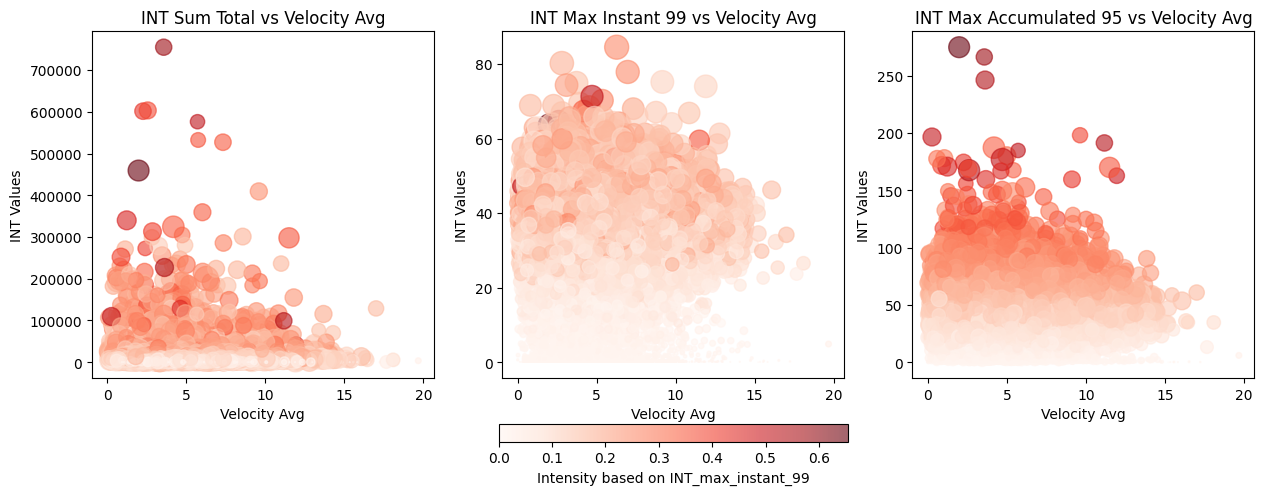

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_ft_precip_vs_vavg(ft):
    fig, axs = plt.subplots(1, 3, figsize=(15, 6))

    # Define data pairs and labels
    data_pairs = [
        (ft['INT_velocityAvg'], ft['INT_sum_total'], "INT Sum Total vs Velocity Avg"),
        (ft['INT_velocityAvg'], ft['INT_max_instant_99'], "INT Max Instant 99 vs Velocity Avg"),
        (ft['INT_velocityAvg'], ft['INT_max_accumulated_95'], "INT Max Accumulated 95 vs Velocity Avg")
    ]

    # Scale point size based on INT_max_accumulated_90 and color based on INT_max_instant_99
    sizes =ft['INT_max_instant_99'] / ft['INT_max_instant_99'].max() *100
    colors =  ft['INT_max_accumulated_90'] / ft['INT_max_accumulated_95'].max()

    for ax, (x_data, y_data, title) in zip(axs, data_pairs):
        scatter = ax.scatter(x_data, y_data, s=3*sizes, c=colors, cmap='Reds', alpha=0.6)
        ax.set_ylabel("INT Values")
        ax.set_xlabel("Velocity Avg")
        ax.set_title(title)

    # Add color bar to reflect intensity of red based on INT_max_instant_99
    cbar = fig.colorbar(scatter, ax=axs.ravel().tolist(),  shrink=0.3, orientation='horizontal', pad=0.1)
    cbar.set_label('Intensity based on INT_max_instant_99')

    # plt.tight_layout()
    plt.show()

# plot_ft_precip_vs_vavg(ft_lowprop)
plot_ft_precip_vs_vavg(ft)

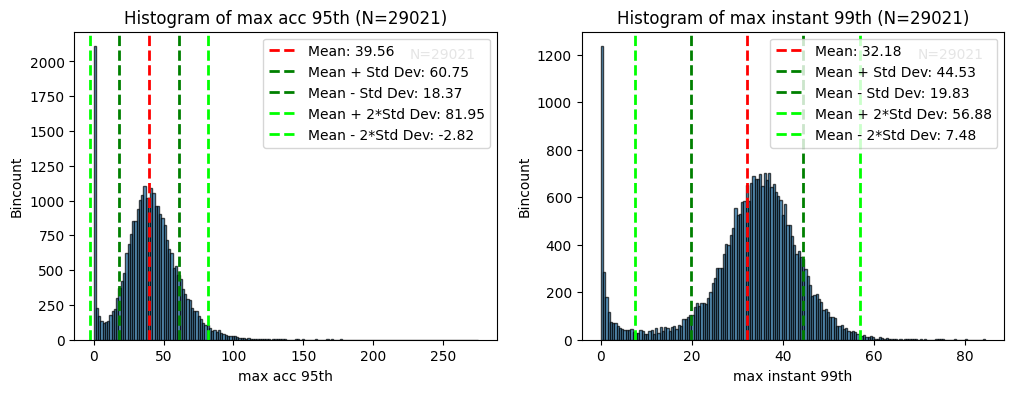

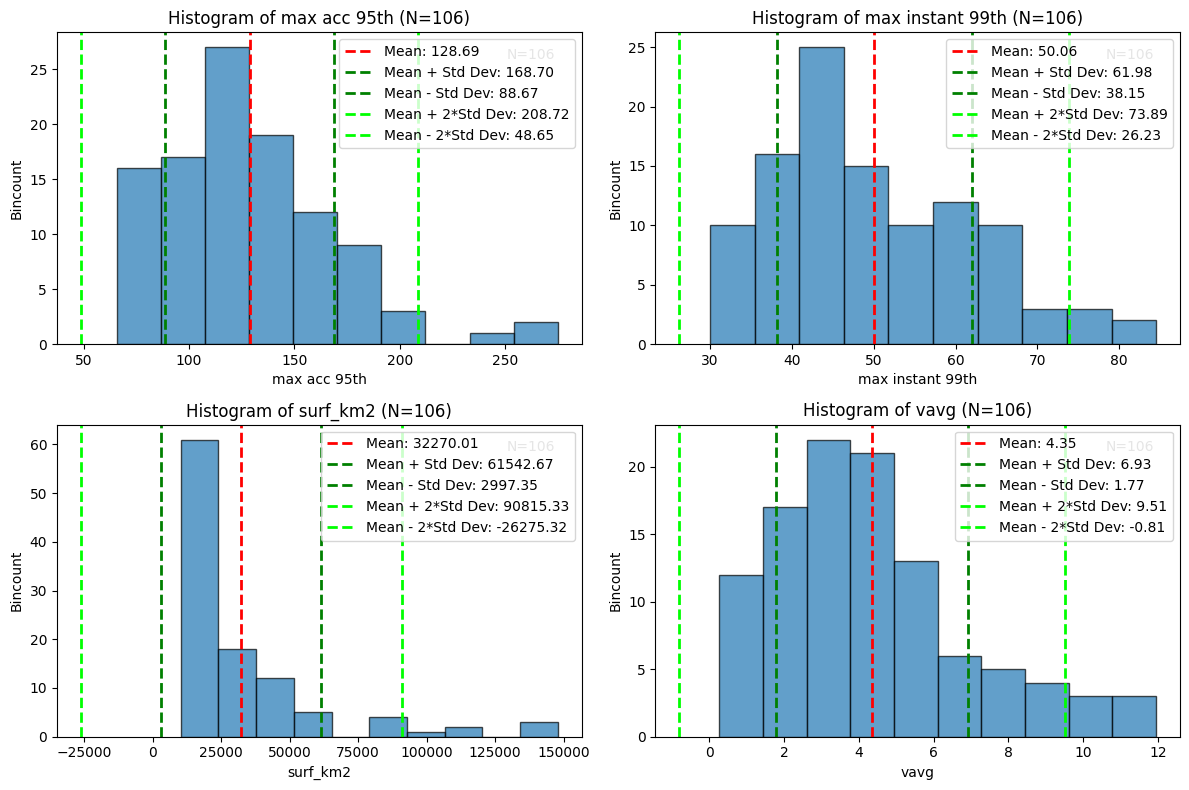

In [6]:
fig, axs = plt.subplots(1, 2, figsize = (12,4))
simple_hist(ft.INT_max_accumulated_95, "max acc 95th", fig = fig, ax = axs[0])
simple_hist(ft.INT_max_instant_99, "max instant 99th", fig = fig, ax = axs[1])

xt =  ft.where((ft.INT_max_accumulated_95)+2*(ft.INT_max_instant_99)>200, drop=True)
# xt =  xt.where(xt.INT_surfmaxkm2_241K <20000, drop=True)

fig, axs = plt.subplots(2, 2, figsize = (12,8))
simple_hist(xt.INT_max_accumulated_95, "max acc 95th", fig = fig, ax = axs.flatten()[0])
simple_hist(xt.INT_max_instant_99, "max instant 99th", fig = fig, ax = axs.flatten()[1])
simple_hist(xt.INT_surfmaxkm2_241K, "surf_km2", fig = fig, ax = axs.flatten()[2])
simple_hist(xt.INT_velocityAvg, "vavg", fig = fig, ax = axs.flatten()[3])
plt.tight_layout()

Text(0.5, 1.0, 'acc_or_inst_extremes_updated_storms_dmin6_smin10000_lat-15_30_lon-180_180.nc')

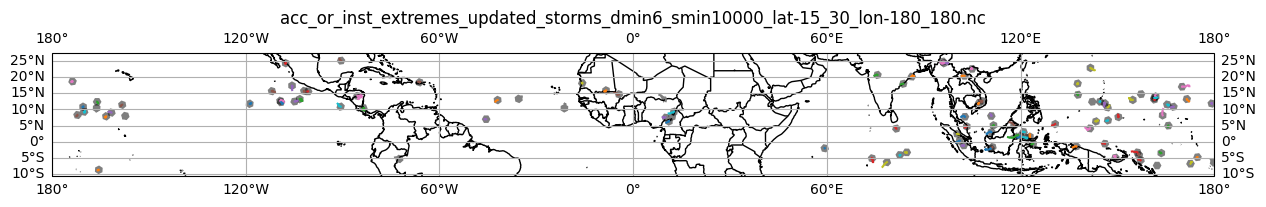

In [7]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
fig, ax = plt.subplots(1, 1, figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.gridlines(draw_labels=True)

for iDCS in xt.DCS_number.values:
    start, end, lons, lats, speeds, times, time_smax, i_smax, lons_3d, lats_3d, speeds_3d, times_3d, speed_lon_3d, speed_lat_3d  = st.get_frame_data(ft, iDCS)
    extents, slices_lon, slices_lat = st.get_extents_slices(lons_3d, lats_3d, large_scale_frame_size = 1.5)
    
    lons = (lons + 180) % 360 - 180
    lons_3d = (lons_3d + 180) % 360 - 180

    lon_smax = lons[i_smax]
    lat_smax =  lats[i_smax]
    lon_propa = lon_smax - lons[0]
    lat_propa = lat_smax - lats[0]

    plt.plot(lons[:i_smax+1], lats[:i_smax+1])
    plt.quiver(lons[0], lats[0], lon_propa, lat_propa, scale=1, alpha = 0.5, angles='xy', scale_units='xy')

plt.title("acc_or_inst_extremes_"+filename_save.split("/")[-1])

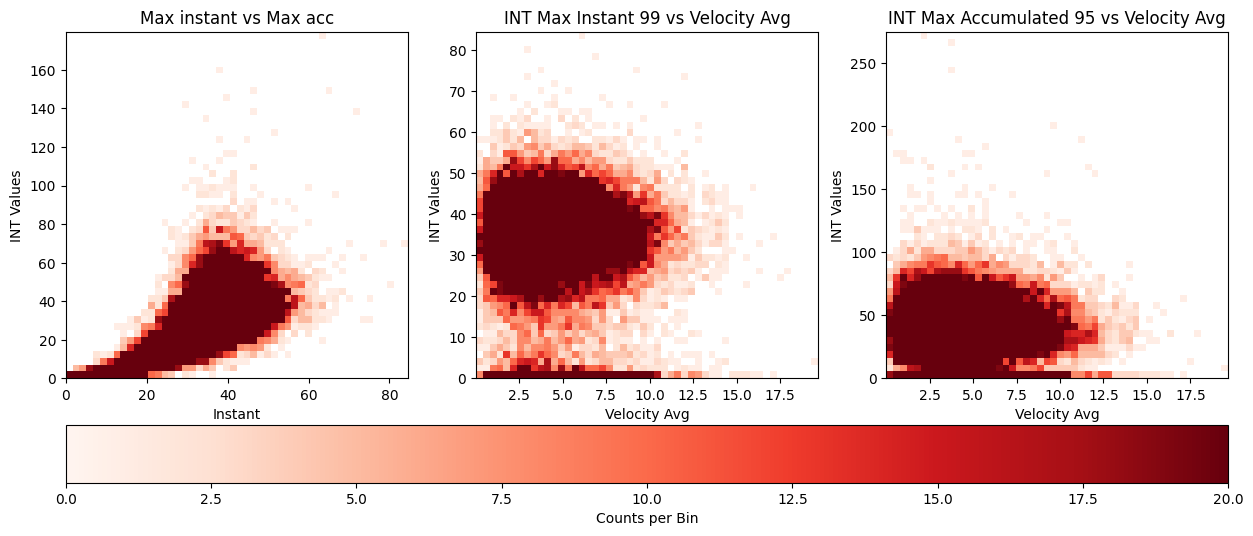

In [8]:
### DENSITY PLOT (good ol' days)

fig, axs = plt.subplots(1, 3, figsize=(15, 6))

# Define data pairs and labels
data_pairs = [
    (ft['INT_max_instant_99'], ft['INT_max_accumulated_90'], "Max instant vs Max acc"),
    (ft['INT_velocityAvg'], ft['INT_max_instant_99'], "INT Max Instant 99 vs Velocity Avg"),
    (ft['INT_velocityAvg'], ft['INT_max_accumulated_95'], "INT Max Accumulated 95 vs Velocity Avg")
]

# Set the number of bins for the histograms
x_bins = 50
y_bins = 50

# Collect all the histogram plots to adjust color scales and add a color bar
histograms = []

# First, find the global maximum count to normalize the color scale across all subplots
max_count = 0
for x_data, y_data, _ in data_pairs:
    counts, _, _ = np.histogram2d(x_data, y_data, bins=[x_bins, y_bins])
    max_count = max(max_count, counts.max())

# Now, create the 2D histograms with consistent color scaling
for ax, i, (x_data, y_data, title) in zip(axs, [0,1,2], data_pairs):
    h = ax.hist2d(
        x_data,
        y_data,
        bins=[x_bins, y_bins],
        cmap='Reds',
        cmin=1,
        vmin=0,
        vmax= 20 #max_count
    )
    ax.set_ylabel("INT Values")
    if i!=0 : ax.set_xlabel("Velocity Avg")
    else : ax.set_xlabel("Instant")
    ax.set_title(title)
    histograms.append(h[3])  # h[3] is the QuadMesh artist

# Add a shared color bar for all subplots
cbar = fig.colorbar(
    histograms[0],
    ax=axs.ravel().tolist(),
    orientation='horizontal',
    pad=0.1
)
cbar.set_label('Counts per Bin')

# plt.tight_layout()
plt.show()


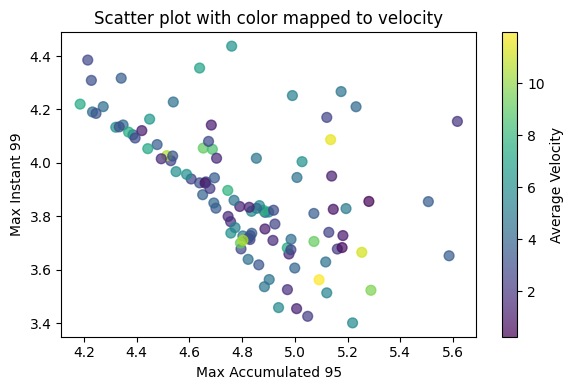

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
scatter = ax.scatter(
    np.log(xt.INT_max_accumulated_95), 
    np.log(xt.INT_max_instant_99), 
    c=xt.INT_velocityAvg, 
    cmap='viridis',  # You can try 'plasma', 'cividis', etc., for a variety of colors
    s=50,            # Adjust size as needed
    alpha=0.7        # Set transparency level to make overlapping points more visible
)

# Add a colorbar to show the velocity values
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Average Velocity')

# Set axis labels
ax.set_xlabel('Max Accumulated 95')
ax.set_ylabel('Max Instant 99')
ax.set_title('Scatter plot with color mapped to velocity')

# Optional: Fine-tune the layout
plt.tight_layout()
plt.show()


In [11]:
sorted_values = xt.DCS_number.values[np.argsort(xt.INT_max_instant_99.values)]
sorted_values

array([282330, 173899, 217922, 260839, 239243, 242805, 283112, 282290,
       181205, 153381, 238454, 220083, 282925, 261677, 282640, 174264,
       283619, 238413, 194718, 238887, 189761, 261186, 261071, 176214,
       261689, 261461, 194750, 218750, 174631, 174486, 215999, 174403,
       194836, 216584, 260941, 238618, 261633, 238425, 221136, 153808,
       155033, 153490, 175016, 283929, 215786, 283292, 239113, 154132,
       262403, 177435, 285704, 175452, 244042, 239952, 283589, 282909,
       262768, 169451, 175731, 283139, 242884, 154065, 240557, 195864,
       285730, 216704, 261064, 282592, 173894, 283746, 153799, 238534,
       176328, 218409, 216541, 177236, 178413, 261082, 176197, 194937,
       219257, 215853, 287111, 156772, 282303, 215734, 174191, 260860,
       153505, 195562, 194954, 194859, 194725, 263873, 262305, 261489,
       153991, 239121, 195186, 261201, 262620, 261498, 176225, 174083,
       261127, 261575])

In [16]:
xt.sel(DCS_number = 261575).INT_max_instant_99

<xarray.DataArray 'INT_max_instant_99' ()>
array(84.51192383)
Coordinates:
    DCS_number  int64 261575